In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import scipy
from pandarallel import pandarallel


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
h5 = '../cerberus_annot.h5'
h5_annot = 'cerberus_annot_triplets.h5'
ab = '../../talon/human_talon_abundance.tsv'
filt_ab = '../cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = '../swan/isos_sample_gene_90.tsv'
mm_tissues = ['adrenal gland', 'heart',
              'muscle', 'brain', 'pgp1_excite_neuron',
              'pgp1_astro', 'h9_osteocyte',
              'h1', 'wtc11']

In [3]:
def compute_centroid(ca, gene=None, subset=None):
    """ 
    Compute the centroid of simplex coordinates for a given set of genes / triplets
    
    Parameters:
        gene (str): Gene ID or name
        subset (dict of str): Subset
    """
    
    df = ca.triplets.copy(deep=True)
    
    if gene:
        df, gene = cerberus.subset_df_on_gene(df, gene)

    # if we have a list of allowed sources, limit to those entries
    if subset:
        df = cerberus.subset_df(df, subset)
    
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    
    df = df[['tss_ratio', 'spl_ratio', 'tes_ratio']]
    centroid = df.mean().tolist()
    
    return centroid

def simplex_dist(a, b, how='js'):
    """
    Compute the distance between two points on a simplex
    
    Parameters:
        a (np.array): Coords of pt a
        b (np.array): Coords of pt b
        how (str): How to calculate distance. {'jensenshannon'}
    
    Returns:
        dist (float): Distance b/w a and b using distance metric
    """
    if how == 'js':
        dist = scipy.spatial.distance.jensenshannon(a,b)
    return dist

def simplex_dist_x(x, suff_a=None, suff_b=None, **kwargs):
    def get_pt(x, suff):
        tss = 'tss_ratio'
        ic = 'spl_ratio'
        tes = 'tes_ratio'
        if suff:
            tss = '{}{}'.format(tss, suff)
            ic = '{}{}'.format(ic, suff)
            tes = '{}{}'.format(tes, suff)
        pt = [x[tss], x[ic], x[tes]]
        return pt
    
    a = get_pt(x, suff_a)
    b = get_pt(x, suff_b)
    dist = simplex_dist(a,b, **kwargs)
    
    return dist

## Compare centroid of all obs protein coding genes to those in each tissue

In [3]:
ca = cerberus.read(h5_annot)

In [69]:
# add biotype to subset on 
gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
gene_df = gene_df[['gid_stable', 'biotype_category']]
gene_df.rename({'gid_stable': 'gid'}, axis=1, inplace=True)
ca.triplets = ca.triplets.merge(gene_df, how='left', on='gid')

In [70]:
# centroid for all obs pc isoforms
pc_subset = {'source': 'obs_det',
             'biotype_category': 'protein_coding'}
pc_pt = compute_centroid(ca, subset=pc_subset)

# loop through each sample
sample_pc_subset = {'source': 'sample_det',
                    'biotype_category': 'protein_coding'}
samples = cerberus.subset_df(ca.triplets.copy(deep=True), sample_pc_subset)['sample'].unique().tolist()
dists = pd.DataFrame()
for s in samples:
    sample_pc_subset['sample'] = s
    s_pt = compute_centroid(ca, subset=sample_pc_subset)
    d = simplex_dist(pc_pt, s_pt, how='js') 
    temp = pd.DataFrame(index=[s], data=[d], columns=['dist'])
    dists = pd.concat([dists, temp], axis=0)

In [42]:
# sample = 'caco2'
# dist = .5
# dists = pd.DataFrame(index = [sample], data = [dist], columns=['dist'])
# dists

In [71]:
dists.to_csv('sample_vs_obs_dists.tsv', sep='\t')

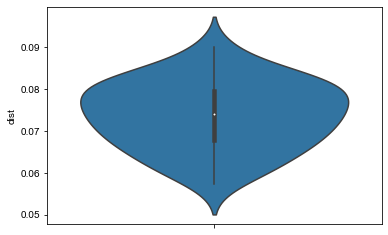

In [73]:
sns.violinplot(data=dists, y='dist')

In [3]:
dists = pd.read_csv('sample_vs_obs_dists.tsv', sep='\t')

In [6]:
dists.sort_values(by='dist', ascending=False).head()

,Unnamed: 0,dist
44,hl60,0.089918
10,pgp1_astro,0.088176
34,pgp1_endo,0.085651
0,caco2,0.083733
35,ocily7,0.083681


## Compare sample to sample major for each gene / sample combination

In [12]:
ca = cerberus.read(h5_annot)

In [37]:
# compute centroid for each sample / gene pairing for the different sources
dists = {}
for source in ['sample_det', 'sample_major']:
    df = ca.triplets.loc[ca.triplets.source == source].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    keep_cols = ['gname', 'sample', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
    df = df[keep_cols]
    df = df.groupby(['sample', 'gname']).mean().reset_index()
    df = assign_sector(df)
    dists[source] = df
    
df = dists['sample_det'].merge(dists['sample_major'],
                               on=['sample', 'gname'],
                               suffixes=('_det', '_major'))
df['same_sector'] = df.sector_det == df.sector_major

In [48]:
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist_x,
                               args=('_det', '_major'),
                               axis=1)
df.sort_values(by='dist', ascending=False)[['gname', 'sample', 'dist']].head()

,gname,sample,dist
150844,COL3A1,h9_chondro,0.533181
379489,COL3A1,imr90,0.517350
117947,PSAP,h1,0.472296
256256,SNX17,hepg2,0.460264
502886,SNX17,ovary,0.460264


In [34]:
# gene tpm differences between the gene / sample combinations 
# that change sectors between all and major centroids
gene_df = pd.read_csv(ab, sep='\t')
gene_df, inds = get_tpm_table(gene_df,
                   groupby='sample',
                   how='gene',
                   min_tpm=1,
                   gene_subset='polya')

gene_df = gene_df.transpose()
gene_df = gene_df.melt(var_name='gid', value_name='tpm', ignore_index=False).reset_index()
gene_df.head()

gtf_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df = gtf_df[['gid_stable', 'gname']]
df = df.merge(gtf_df, how='left', on='gname')

df = df.merge(gene_df, how='left', left_on=['sample', 'gid_stable'], right_on=['biosample', 'gid'])
print(len(df.loc[df.tpm == 0].index))
df = df.loc[df.tpm != 0]
df['log_tpm'] = np.log2(df.tpm)
sns.displot(data=df, x='log_tpm', hue='same_sector', kind='kde', common_norm=False)

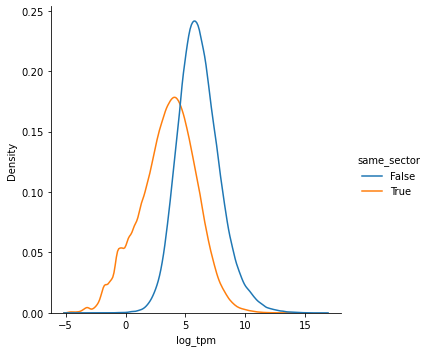

## Compare centroid of obs vs. obs major for each gene


In [4]:
ca = cerberus.read(h5_annot)

In [5]:
# compute centroid for each sample / gene pairing for the different sources
dists = {}
for source in ['sample_det', 'sample_major']:
    df = ca.triplets.loc[ca.triplets.source == source].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    keep_cols = ['gname', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
    df = df[keep_cols]
    df = df.groupby(['gname']).mean().reset_index()
    df = assign_sector(df)
    dists[source] = df
    
df = dists['sample_det'].merge(dists['sample_major'],
                               on=['gname'],
                               suffixes=('_det', '_major'))
df['same_sector'] = df.sector_det == df.sector_major

In [6]:
df.head()

,gname,tss_ratio_det,tes_ratio_det,spl_ratio_det,n_iso_det,sector_det,tss_ratio_major,tes_ratio_major,spl_ratio_major,n_iso_major,sector_major,same_sector
0,A1BG,0.319290,0.385809,0.294900,1.365854,mixed,0.327421,0.354028,0.318551,1.097561,mixed,True
1,A1BG-AS1,0.219166,0.425003,0.355831,4.175000,mixed,0.219117,0.409051,0.371832,3.775000,mixed,True
2,A1CF,0.252991,0.394872,0.352137,5.222222,mixed,0.240121,0.341780,0.418100,3.444444,mixed,True
3,A2M,0.372135,0.232627,0.395238,4.666667,mixed,0.354545,0.327273,0.318182,1.100000,mixed,True
4,A2M-AS1,0.333333,0.333333,0.333333,1.000000,simple,0.333333,0.333333,0.333333,1.000000,simple,True


In [7]:
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist_x,
                               args=('_det', '_major'),
                               axis=1)
df.sort_values(by='dist', ascending=False)[['gname', 'dist']].head()

,gname,dist
22679,SNX17,0.368569
20824,RPL41,0.338410
2765,CCT7,0.318110
2767,CCT8,0.316568
18244,PDIA6,0.314254


In [63]:
len(df.index)

26770

In [65]:
df.head()

,gname,tss_ratio_det,tes_ratio_det,spl_ratio_det,n_iso_det,sector_det,tss_ratio_major,tes_ratio_major,spl_ratio_major,n_iso_major,sector_major,same_sector
0,A1BG,0.319290,0.385809,0.294900,1.365854,mixed,0.327421,0.354028,0.318551,1.097561,mixed,True
1,A1BG-AS1,0.219166,0.425003,0.355831,4.175000,mixed,0.219117,0.409051,0.371832,3.775000,mixed,True
2,A1CF,0.252991,0.394872,0.352137,5.222222,mixed,0.240121,0.341780,0.418100,3.444444,mixed,True
3,A2M,0.372135,0.232627,0.395238,4.666667,mixed,0.354545,0.327273,0.318182,1.100000,mixed,True
4,A2M-AS1,0.333333,0.333333,0.333333,1.000000,simple,0.333333,0.333333,0.333333,1.000000,simple,True


In [64]:
n_genes = len(ca.triplets.gname.unique().tolist())
print(n_genes)

52204


In [76]:
sample_subset = {'source': 'sample_det'}
major_subset = {'source': 'sample_major'}
dists = pd.DataFrame()

for i, gname in enumerate(ca.triplets.gname.unique().tolist()):
    sample_pt = compute_centroid(ca, subset=sample_subset, gene=gname)
    major_pt = compute_centroid(ca, subset=major_subset, gene=gname)
    d = simplex_dist(sample_pt, major_pt, how='js')
    if d == np.nan:
        pdb.set_trace()
    temp = pd.DataFrame(index=[gname], data=[d], columns=['dist'])
    dists = pd.concat([dists, temp], axis=0)   
    if i % 2000 == 0:
        print(i)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000


In [77]:
# dists.to_csv('dists_221001.tsv', sep='\t')

In [8]:
dists = pd.read_csv('dists_221001.tsv', sep='\t')

In [9]:
len(dists.index)

52204

In [10]:
dists.sort_values(by='dist', ascending=False).head(20)
# dists.loc[dists['Unnamed: 0'] == 'COL3A1']

,Unnamed: 0,dist
4291,SNX17,0.368569
19662,RPL41,0.338410
6886,CCT7,0.318110
9585,CCT8,0.316568
8200,PDIA6,0.314254
11238,PSMC3,0.308154
16384,RPL10A,0.306801
16104,PSAP,0.301065
10759,H2AZ1,0.298096
15754,XRCC6,0.294567


In [5]:
# plot major and all isoforms for a given gene
def plot_all_major_isos(ca, gene):
    
    c_dict, order = get_biosample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2'}
    
    # all 
    subset = {'source': ['v40', 'obs_det', 'sample_det']}
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset={'source': ['v40', 'obs_det', 'sample_det']},
                size_scale=0.5,
                fname='figures/simplex_{}.pdf'.format(gene.lower()))

    # major
    subset = {'source': ['v40', 'obs_det', 'sample_det']}
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset={'source': ['v40', 'obs_det', 'sample_major']},
                size_scale=0.5,
                fname='figures/simplex_{}_major.pdf'.format(gene.lower()))

In [ ]:
# dists.loc[dists['Unnamed: 0']=='COL1A1']

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


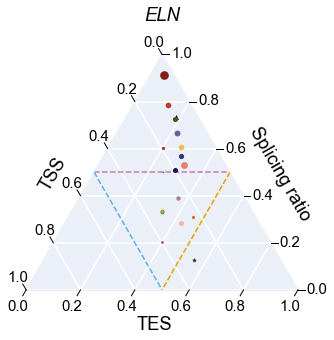

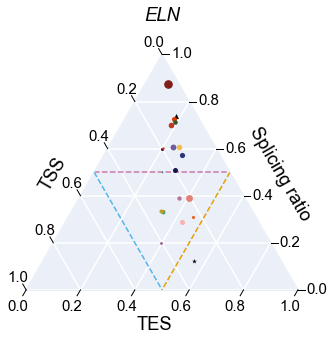

In [8]:
plot_all_major_isos(ca, 'ELN')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


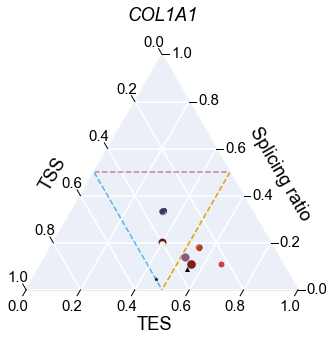

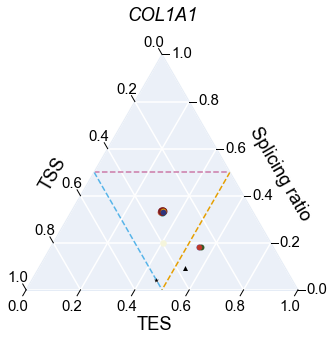

In [7]:
plot_all_major_isos(ca, 'COL1A1')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


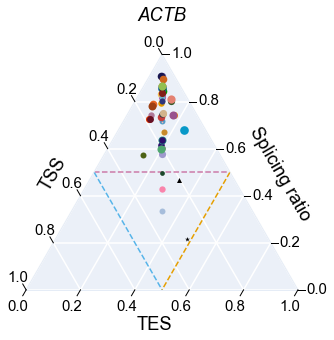

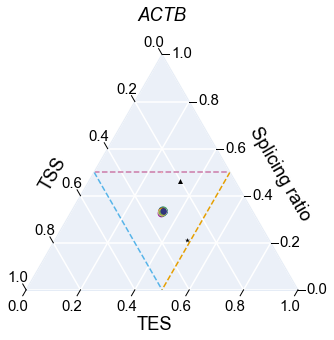

In [64]:
plot_all_major_isos(ca, 'ACTB')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


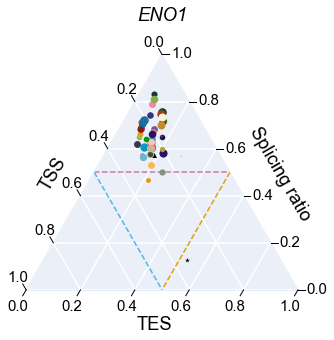

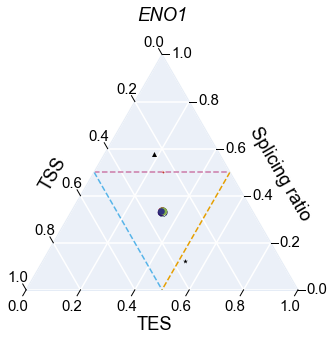

In [65]:
plot_all_major_isos(ca, 'ENO1')

2.5
75.0
(5.358, 5.0)
2.5
75.0
(5.358, 5.0)


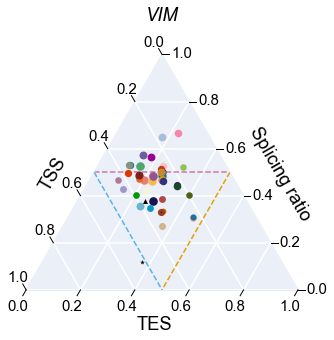

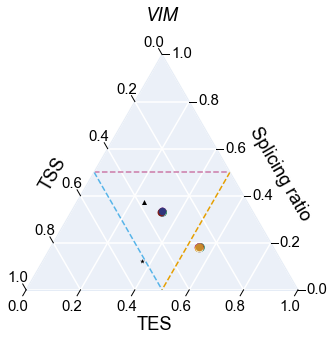

In [66]:
plot_all_major_isos(ca, 'VIM')

## scratch

In [26]:
# c = compute_centroid(ca, subset = {'source': 'obs_det', 'biotype_category': 'protein_coding'})
# a = compute_centroid(ca,
#                      gene='MEF2C',
#                      subset={'source': 'obs_det'})
# a = compute_centroid(ca,
#                      gene='ELN',
#                      subset={'source': 'obs_det'})
# b = compute_centroid(ca,
#                      gene='COL3A1',
#                      subset={'source': 'obs_det'})
# print(a)
# print(b)

[0.07894736842105263, 0.7368421052631579, 0.18421052631578946]
[0.0425531914893617, 0.8297872340425532, 0.1276595744680851]


In [28]:
simplex_dist(a,b, how='js')

0.0820051749277829